In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from fenics import *
from mshr import *
import numpy as np
import os

In [2]:
os.chdir('/media/erick/TOSHIBA EXT/regular_alpha_07')

In [3]:
def correlation_2D(step):
    #obten el módulo del promedio del espectro de potencias
    abs_n = "FFT_" + "N_" + str(step) + ".txt"
    abs_p = "FFT_" + "P_" + str(step) + ".txt"
    mod_n = np.loadtxt(abs_n, float)
    mod_p = np.loadtxt(abs_p, float)
    
    # calcula la inversa del modulo al cuadrado
    n2_inv = np.fft.ifftn(mod_n**2)
    max_fft_n2_inv = np.where(n2_inv == n2_inv.max())
    n2_inv[max_fft_n2_inv[0][0],max_fft_n2_inv[1][0]] = 0   
    p2_inv = np.fft.ifftn(mod_p**2)
    max_fft_p2_inv = np.where(p2_inv == p2_inv.max())
    p2_inv[max_fft_p2_inv[0][0],max_fft_p2_inv[1][0]] = 0
    np_inv = np.fft.ifftn(mod_n*mod_p)
    max_fft_np_inv = np.where(np_inv == np_inv.max())
    np_inv[max_fft_np_inv[0][0],max_fft_np_inv[1][0]] = 0
 
    #Desplace el componente de frecuencia cero al centro del espectro.
    n2_inv = np.fft.fftshift(n2_inv)
    p2_inv = np.fft.fftshift(p2_inv)
    np_inv = np.fft.fftshift(np_inv)

    # Obten el valor absoluto de la tranformada inversa
    file_abs_n  = np.abs(n2_inv)
    file_abs_p  = np.abs(p2_inv)
    file_abs_np = np.abs(np_inv)
    mean_n = np.mean(file_abs_n)
    mean_p = np.mean(file_abs_p)
    std_n = np.std(mod_n)
    std_p =  np.std(mod_p)
    
    #Calcula las correlaciones
    corr_nn = (file_abs_n - mean_n**2) / (std_n*std_n)
    corr_pp = (file_abs_p - mean_p**2) / (std_p*std_p)
    corr_np = (file_abs_np - mean_n*mean_p) / (std_n*std_p)

    matrix_corr_nn_file = "matrix_corr" + "_nn_" + str(t) + ".txt"
    np.savetxt(matrix_corr_nn_file, corr_nn, delimiter="\t")
    matrix_corr_pp_file = "matrix_corr" + "_pp_" + str(t) + ".txt"
    np.savetxt(matrix_corr_pp_file, corr_pp, delimiter="\t")
    matrix_corr_np_file = "matrix_corr" + "_np_" + str(t) + ".txt"
    np.savetxt(matrix_corr_np_file, corr_np, delimiter="\t")
    return None

In [4]:
def polar_mean(step, corr_type):
    matrix_file = "matrix_corr_" + corr_type + "_" + str(step) + ".txt"
    matrix = np.loadtxt(matrix_file, float)
    n = len(matrix)  
    dk = 1.0
    p = np.zeros(int(n/2))
    for i in range(1,int(n/2)): 
        k = dk*i
        suma = 0.
        dtheta = np.pi/90. # two degrees
        
        for j in range (1,180):
            theta = j * dtheta    
            nx = int(k*np.cos(theta)/dk - n/2)
            ny = int(k*np.sin(theta)/dk - n/2)
            suma += matrix[nx,ny]        
        p[i] = suma/180.
        
    filename = "correlation_" + corr_type + "_" + str(step) + ".txt"         
    np.savetxt(filename, p, delimiter="\n")
    return None

In [5]:
def axis_mean(step, corr_type):
    matrix_file = "matrix_corr_" + corr_type + "_" + str(step) + ".txt"
    matrix = np.loadtxt(matrix_file, float)
    x_mean =  np.mean(matrix, axis=0)
    y_mean =  np.mean(matrix, axis=1)
    
    filename_x = "correlation_mean_x" + corr_type + "_" + str(step) + ".txt"         
    np.savetxt(filename_x, x_mean, delimiter="\n")
    filename_y = "correlation_mean_y" + corr_type + "_" + str(step) + ".txt"         
    np.savetxt(filename_y, y_mean, delimiter="\n")
    return None

In [6]:
def get_correlation(step, corr_type):
    file = "correlation_"+corr_type+"_"+str(step)+".txt"
    corr = np.loadtxt(file, float)
    return corr

In [7]:
def plot_correlations_3d(corr_type, time_steps):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    # plot a 3D surface like in the example mplot3d/surface3d_demo
    X = np.arange(0, 35, 1)
    Y = np.arange(20, time_steps, 5)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([get_correlation(i, corr_type) for i in range(20, time_steps, 5)])

    surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=1, alpha=1, cmap='Reds', linewidth=0.3, edgecolors='black')
    fig.colorbar(surf, shrink=0.3, aspect=8, location='left', ax=ax)

    ax.view_init(15, 55)
#    ax.set_zlim(bottom=0)
    ax.set_xlim(0,35)
    ax.set_ylim(20,time_steps)

    ax.set_xlabel('Number wave "r"', fontsize=15)
    ax.set_ylabel('Time step', fontsize=15)
    ax.set_zlabel('P(k,t)', fontsize=15)
    plt.savefig("correlations_3D_{}.png".format(corr_type))
    return plt.show()

In [8]:
def plot_contour(corr_type, time_steps):
    fig, ax = plt.subplots(figsize=(12,6))

    # plot a 3D surface like in the example mplot3d/surface3d_demo
    Y = np.arange(0, time_steps, 5)
    X = np.arange(0, 35, 1)
    X,Y  = np.meshgrid(X, Y)
    Z = np.array([get_correlation(i, corr_type) for i in range(0, time_steps, 5)])
    
    CS = ax.contour(X, Y, Z, levels = [0.25, 0.5, 0.75])
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Correlation length' + ' ' + corr_type)
    
#    ax.set_xlim(0,15)
    plt.savefig("correlations_length_{}.png".format(corr_type))
    return plt.show()

In [9]:
# Time parameters
dt = 5 # step
T = 3000 # end step
nb = 100

In [13]:
t = 0  # zero time
while t <= T:
    correlation_2D(t)
    t += dt

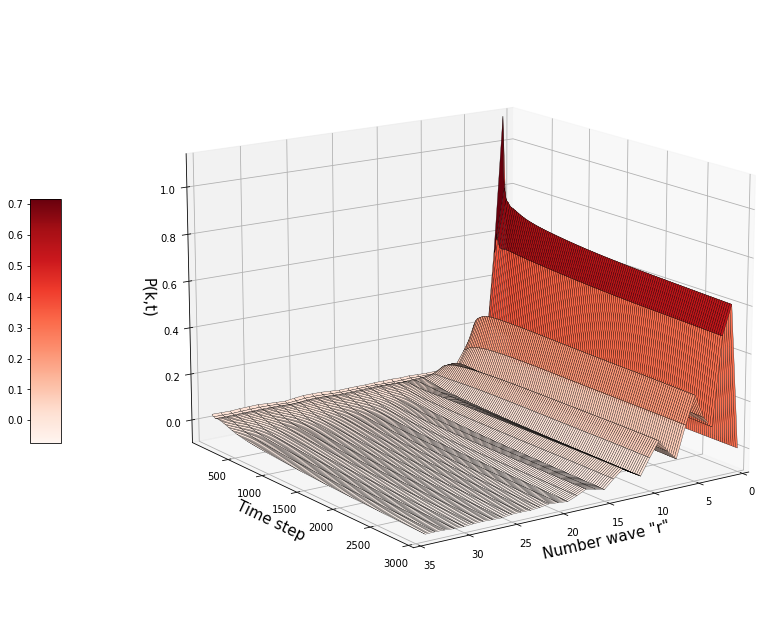

In [14]:
t = 0  # zero time
while t < T:
    polar_mean(t, "nn")
    t += dt
plot_correlations_3d('nn', T)

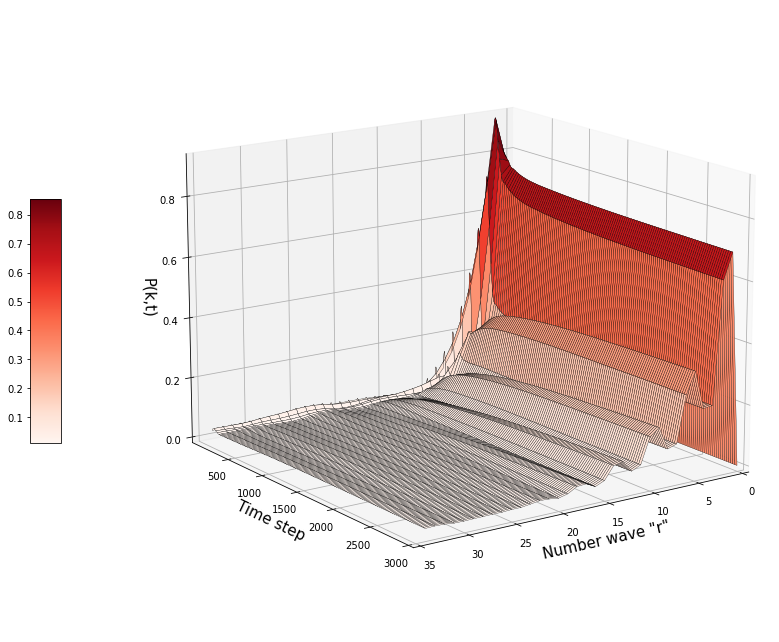

In [15]:
t = 0  # zero time
while t < T:
    polar_mean(t, "pp")
    t += dt
plot_correlations_3d('pp', T)

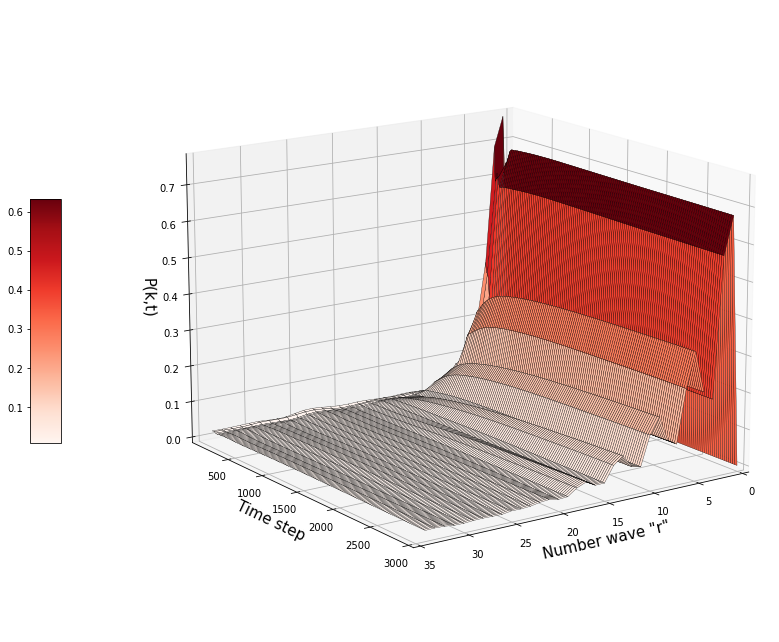

In [16]:
t = 0  # zero time
while t < T:
    polar_mean(t, "np")
    t += dt
plot_correlations_3d('np', T)

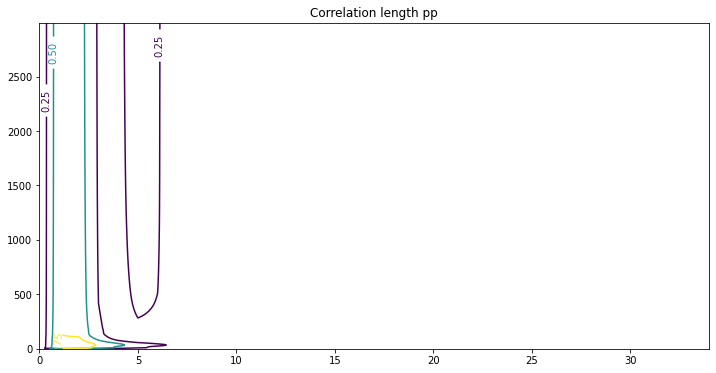

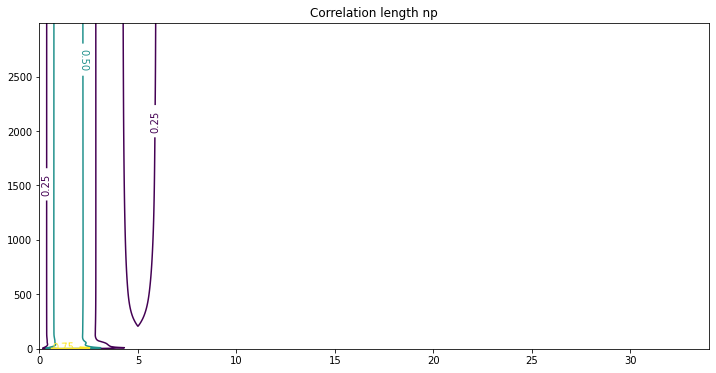

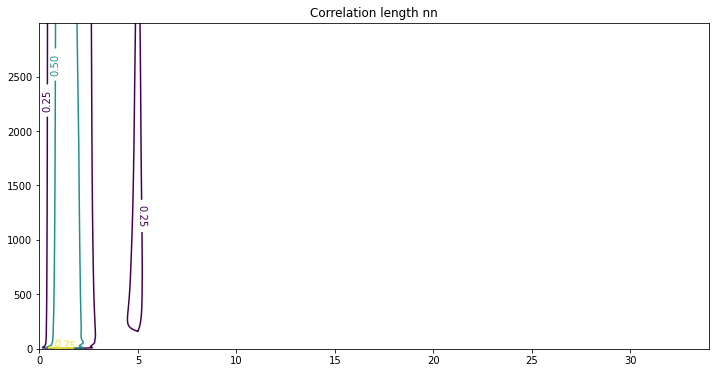

In [17]:
plot_contour('pp', T)
plot_contour('np', T)
plot_contour('nn', T)